In [1]:
import sys
# import pyccl as ccl
import pickle
import camb
from skylens import *
from survey_utils import *
import seaborn as sns
colors=sns.color_palette()
markers=['o','s','^','>','v']

In [2]:
ncpu=2
LC,scheduler_info=start_client(Scheduler_file=None,local_directory=None,ncpu=None,n_workers=ncpu,threads_per_worker=1,
                              memory_limit='120gb',dashboard_address=8811,processes=True)
client=client_get(scheduler_info=scheduler_info)

Start_client: No scheduler file, will start local cluster at  ./temp_skylens/pid6509/


In [3]:
s1_s2s={}
s1_s2s[corr_gg]=(0,0)
s1_s2s[corr_ll]=[(2,2),(2,-2)]
s1_s2s[corr_ggl]=(0,2)

In [4]:
fig_home='./figures/'

In [5]:
corr_labels={corr:{} for corr in s1_s2s.keys()}
corr_labels[corr_ll][(2,2)]=r'$\xi_+$'
corr_labels[corr_ll][(2,-2)]=r'$\xi_-$'
corr_labels[corr_gg][(0,0)]=r'$gg$'
corr_labels[corr_ggl][(0,2)]=r'$g\gamma$'

corr_fnames={corr:{} for corr in s1_s2s.keys()}
corr_fnames[corr_ll][(2,2)]='llp'
corr_fnames[corr_ll][(2,-2)]='llm'
corr_fnames[corr_gg][(0,0)]='gg'
corr_fnames[corr_ggl][(0,2)]='ggl'

In [6]:
wigner_files={}
home='/verafs/scratch/phy200040p/sukhdeep/physics2/skylens/'
wig_home=home+'temp/'
wigner_files[0]= wig_home+'/dask_wig3j_l2200_w4400_0_reorder.zarr'
# wigner_files[0]= wig_home+'/dask_wig3j_l3500_w2100_0_reorder.zarr'
wigner_files[2]= wig_home+'/dask_wig3j_l2200_w4400_2_reorder.zarr'

wigner_step=100

In [7]:
test=False

In [8]:
nside=1024
if test:
    nside=64
use_window=True
unit_window=False
f_sky=0.3

do_pseudo_cl=True
do_xi=True

bin_cl=True
bin_xi=True

use_binned_l=True
use_binned_theta=True

store_win=True

nz_PS=50

do_cov=True
SSV_cov=False
tidal_SSV_cov=False
Tri_cov=False

In [9]:
??lsst_source_tomo_bins

In [10]:
z0=1 #1087
shear_zbins=lsst_source_tomo_bins(nbins=1,use_window=use_window,nside=nside,f_sky=f_sky,unit_win=unit_window)
galaxy_zbins=shear_zbins

ns0:  27.0
[0.10002    0.10082016 0.10162032 ... 2.99819964 2.9989998  2.99979996] 100 5
source_tomo_bins, zmax 5.0 2.999799959991998 0.5999699939987997
Tracer utils has no tracers
Tracer utils has tracers:  ['galaxy']
pk_params dict was none, intialized with default
cosmo_params dict was none, intialized with default
cosmology interpolation range 0.0 5.015
power spectra camb_pk_too_many_z
Win gen: step size 273 3072 31.0 10
Window done. Size: 0.0


/verafs/scratch/phy200040p/sukhdeep/miniconda3/lib/python3.8/site-packages/skylens-0.1-py3.8.egg/skylens/cov_utils.py:92: RuntimeWarning: invalid value encountered in true_divide
/verafs/scratch/phy200040p/sukhdeep/miniconda3/lib/python3.8/site-packages/skylens-0.1-py3.8.egg/skylens/angular_power_spectra.py:23: RuntimeWarning: divide by zero encountered in true_divide
/verafs/scratch/phy200040p/sukhdeep/miniconda3/lib/python3.8/site-packages/skylens-0.1-py3.8.egg/skylens/angular_power_spectra.py:115: RuntimeWarning: divide by zero encountered in true_divide


scatter_dict got empty dictionary
cl graph done
gather_dict got empty dictionary


/verafs/home/sukhdeep/.local/lib/python3.8/site-packages/healpy-1.14.0-py3.8-linux-x86_64.egg/healpy/sphtfunc.py:433: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  warnings.warn(
/verafs/home/sukhdeep/.local/lib/python3.8/site-packages/healpy-1.14.0-py3.8-linux-x86_64.egg/healpy/sphtfunc.py:822: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  warnings.warn(
/verafs/home/sukhdeep/.local/lib/python3.8/site-packages/healpy-1.14.0-py3.8-linux-x86_64.egg/healpy/sphtfunc.py:827: UserWarning: -> fwhm is 0.000000 arcmin
  warnings.warn(
/verafs/scratch/phy200040p/sukhdeep/project/skylens/skylens/survey_utils.py:126: RuntimeWarning: invalid value encountered in sqrt
  cl_map_noise=np.sqrt(cl_map)
/verafs/scratch/phy200040p/sukhdeep/project/skylens/skylens/survey_utils.py:132: RuntimeWarning: invalid value encountered in sqrt
  shear_zbins[i]['window_N']=np.sqrt(sh

/verafs/home/sukhdeep/.local/lib/python3.8/site-packages/healpy-1.14.0-py3.8-linux-x86_64.egg/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/verafs/home/sukhdeep/.local/lib/python3.8/site-packages/healpy-1.14.0-py3.8-linux-x86_64.egg/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/verafs/home/sukhdeep/.local/lib/python3.8/site-packages/healpy-1.14.0-py3.8-linux-x86_64.egg/healpy/projaxes.py:922: MatplotlibDepr

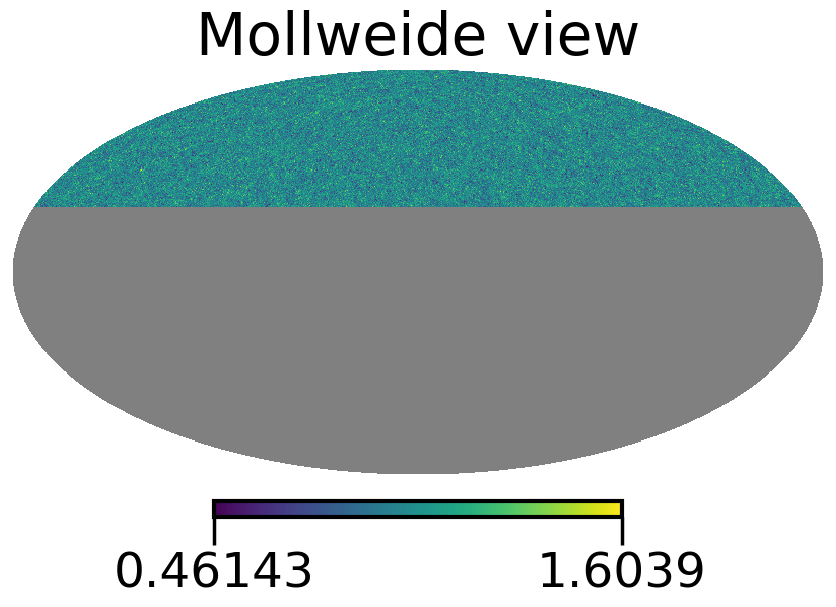

In [11]:
hp.mollview(shear_zbins[0]['window'])

In [12]:
corrs=[corr_ll]#corr_ll,corr_gg,corr_ggl]

In [13]:
bi=(0,0)
corr=corrs[0]
s=s1_s2s[corr]
if corr==corr_ll:
    s=(2,-2)

In [14]:
#setup parameters
lmax_cl=1024 #2000
lmin_cl=0
if test:
    lmax_cl=nside
l0=np.arange(lmin_cl,lmax_cl)

window_lmax=lmax_cl*2

lmin_cl_Bins=lmin_cl+2
lmax_cl_Bins=lmax_cl-10
Nl_bins=25
if test:
    Nl_bins=10
l_bins=get_l_bins(l_min=lmin_cl_Bins,l_max=lmax_cl_Bins,N_bins=Nl_bins,binning_scheme='log',min_modes=5)#,binning_mode='decreasing')
l_bins=l_bins[l_bins<=lmax_cl_Bins]
l_bins0=l_bins*1.
# l_bins=np.unique(np.int64(np.logspace(np.log10(lmin_cl_Bins),np.log10(lmax_cl_Bins),Nl_bins+1)))
lb=.5*(l_bins[1:]+l_bins[:-1])
lb_cl=lb*1.
l_bins_center=lb*1
Nl_bins=len(lb)

# l=np.unique(np.int64(np.logspace(np.log10(lmin_cl),np.log10(lmax_cl),Nl_bins*20))) #if we want to use fewer ell
l=l0

In [15]:
Skylens_kwargs=parse_dict(locals())

Skylens_kwargs['do_pseudo_cl']=True
Skylens_kwargs['do_xi']=False
kappa_cl0=Skylens(**Skylens_kwargs)

Skylens_kwargs_nW=copy.deepcopy(Skylens_kwargs)
Skylens_kwargs_nW['use_window']=False
kappa_cl0_nW=Skylens(**Skylens_kwargs_nW)

Tracer utils has tracers:  ['shear', 'galaxy']
pk_params dict was none, intialized with default
cosmo_params dict was none, intialized with default
cosmology interpolation range 0.0 5.015
power spectra camb_pk_too_many_z
Win gen: step size 100 1024 2049.0 2
Window done. Size: 0.0
Tracer utils has tracers:  ['shear', 'galaxy']
pk_params dict was none, intialized with default
cosmo_params dict was none, intialized with default
cosmology interpolation range 0.0 5.015
power spectra camb_pk_too_many_z
Win gen: step size 100 25 2049.0 2
Window done. Size: 0.0
scatter_dict got empty dictionary
cl graph done
gather_dict got empty dictionary
scatter_dict got empty dictionary
cl graph done
gather_dict got empty dictionary
set binned measure done
Tracer utils has tracers:  ['shear', 'galaxy']
pk_params dict was none, intialized with default
cosmo_params dict was none, intialized with default
cosmology interpolation range 0.0 5.015
power spectra camb_pk_too_many_z
Win gen: step size 100 1024 2049.

In [16]:
#setup parameters
lmax_cl=3*nside-1 #5000
lmin_cl=0
l0=np.arange(lmin_cl,lmax_cl)

window_lmax=min(lmax_cl,3*nside-1)

lmin_cl_Bins=lmin_cl+2
lmax_cl_Bins=lmax_cl-10
Nl_bins2=10
if test:
    Nl_bins2=10
l_bins2=np.unique(np.int64(np.logspace(np.log10(l_bins0.max()),np.log10(lmax_cl_Bins),Nl_bins2+1)))
l_bins=np.unique(np.append(l_bins,l_bins2))
# l_bins0=l_bins*1.
# l_bins=get_l_bins(l_min=lmin_cl_Bins,l_max=lmax_cl_Bins,N_bins=Nl_bins,binning_scheme='log',min_modes=50)#,binning_mode='decreasing')
# l_bins=l_bins[l_bins<=lmax_cl_Bins]
# l_bins=np.unique(np.int64(np.logspace(np.log10(lmin_cl_Bins),np.log10(lmax_cl_Bins),Nl_bins+1)))
lb=.5*(l_bins[1:]+l_bins[:-1])
lb_xi=lb*1.
l_bins_center=lb*1
Nl_bins=len(lb)

# l=np.unique(np.int64(np.logspace(np.log10(lmin_cl),np.log10(lmax_cl),Nl_bins*20))) #if we want to use fewer ell
l=l0

In [17]:
do_xi=True

theta_min=0.1/60
# theta_min=hp.nside2resol(512, arcmin = True)/60 #100/nside #1./60
theta_max=1200./60
n_theta_bins=51
# theta_bins,th=get_theta_bins(theta_min=theta_min,theta_max=theta_max,N_bins=n_theta_bins,binning_scheme='log',n_theta_samples=40)#,max_modes=1)
theta_bins=np.logspace(np.log10(theta_min),np.log10(theta_max),n_theta_bins+1)
th=np.logspace(np.log10(theta_min),np.log10(theta_max),n_theta_bins*80)
theta_bins_center=0.5*(theta_bins[1:]+theta_bins[:-1])
thb=theta_bins_center*1
n_theta_bins=len(thb)

#Hankel Transform setup
WT_kwargs={'l':l0,'l_cut_weights':np.ones_like(l0),'theta':th*d2r,'s1_s2':[(2,2),(2,-2),(0,0)],
           'wig_d_taper_order_low':16,'wig_d_taper_order_high':20}
# if globals().get('WT') is None:
WT=wigner_transform(**WT_kwargs )
# WT_b=wigner_transform(**WT_kwargs)
WT_b=WT
WT.gather_data()

/verafs/scratch/phy200040p/sukhdeep/miniconda3/lib/python3.8/site-packages/skylens-0.1-py3.8.egg/skylens/wigner_functions.py:46: RuntimeWarning: invalid value encountered in true_divide


Wigner ell max of  3070  too low for theta_min. Recommendation based on first few zeros of bessel  (2, 2)  : [ 82671.8129527  189766.30698117 297493.25187861 405363.09440321
 513287.1413721 ]


/verafs/scratch/phy200040p/sukhdeep/miniconda3/lib/python3.8/site-packages/skylens-0.1-py3.8.egg/skylens/wigner_transform.py:120: RuntimeWarning: divide by zero encountered in true_divide
/verafs/scratch/phy200040p/sukhdeep/miniconda3/lib/python3.8/site-packages/skylens-0.1-py3.8.egg/skylens/wigner_transform.py:120: RuntimeWarning: invalid value encountered in true_divide
/verafs/scratch/phy200040p/sukhdeep/miniconda3/lib/python3.8/site-packages/skylens-0.1-py3.8.egg/skylens/wigner_transform.py:120: RuntimeWarning: invalid value encountered in cos


Wigner ell max of  3070  too low for theta_min. Recommendation based on first few zeros of bessel  (2, -2)  : [260867.99699826 380376.69313768 494091.41530841 605592.30401974
 715977.21518152]
Wigner ell max of  3070  too low for theta_min. Recommendation based on first few zeros of bessel  (0, 0)  : [ 82671.8129527  189766.30698117 297493.25187861 405363.09440321
 513287.1413721 ]
l_cut_coupling: (4080, 4080) (4080,) (4080, 4080)
l_cut_coupling: (4080, 4080) (4080,) (4080, 4080)
l_cut_coupling: (4080, 4080) (4080,) (4080, 4080)
Scattering WT data 1


In [18]:
client

Client Scheduler: tcp://127.0.0.1:33719 Dashboard: http://127.0.0.1:8811/status,Cluster Workers: 2 Cores: 2 Memory: 240.00 GB


In [19]:
Skylens_kwargs=parse_dict(locals())
Skylens_kwargs['do_pseudo_cl']=False
kappa_xi0=Skylens(**Skylens_kwargs)

Tracer utils has tracers:  ['shear', 'galaxy']
pk_params dict was none, intialized with default
cosmo_params dict was none, intialized with default
cosmology interpolation range 0.0 5.015
power spectra camb_pk_too_many_z
Win gen: step size 100 3071 3072.0 2
Window done. Size: 0.0
Tracer utils has tracers:  ['shear', 'galaxy']
pk_params dict was none, intialized with default
cosmo_params dict was none, intialized with default
cosmology interpolation range 0.0 5.015
power spectra camb_pk_too_many_z
Win gen: step size 100 35 3072.0 2
Window done. Size: 0.0
Tracer utils has tracers:  ['shear', 'galaxy']
pk_params dict was none, intialized with default
cosmo_params dict was none, intialized with default
cosmology interpolation range 0.0 5.015
power spectra camb_pk_too_many_z
Win gen: step size 100 3071 3072.0 2
scatter dict was passed a future, gathering and re-scattering l_cl
scatter dict was passed a future, gathering and re-scattering l_cl
set window_cl: cl0,cl_b done 0.00022959709167480

In [20]:
Skylens_kwargs_ub=copy.deepcopy(Skylens_kwargs)
Skylens_kwargs_ub['use_binned_l']=False
Skylens_kwargs_ub['use_binned_theta']=False
kappa_xi0_ub=Skylens(**Skylens_kwargs_ub)

Tracer utils has tracers:  ['shear', 'galaxy']
pk_params dict was none, intialized with default
cosmo_params dict was none, intialized with default
cosmology interpolation range 0.0 5.015
power spectra camb_pk_too_many_z
Win gen: step size 100 3071 3072.0 2
scatter dict was passed a future, gathering and re-scattering l_cl
scatter dict was passed a future, gathering and re-scattering l_cl
set window_cl: cl0,cl_b done 0.0001544952392578125
set window_cl: cl done 4.711969375610352 1027.959 0.001
Win_cli ('shear', 'shear', 0, 0) ('shear', 'shear') (0, 0)
set window_cl: cl done 5.816312789916992 1027.959 0.001
cl+cov bags done 1 1 6.679905414581299
set_window_cl done 407.7284984588623
Got xi win graph
Window done. Size: 1598.188


In [21]:
Skylens_kwargs_nW=copy.deepcopy(Skylens_kwargs)
Skylens_kwargs_nW['use_window']=False
kappa_xi0_nW=Skylens(**Skylens_kwargs_nW)

Tracer utils has tracers:  ['shear', 'galaxy']
pk_params dict was none, intialized with default
cosmo_params dict was none, intialized with default
cosmology interpolation range 0.0 5.015
power spectra camb_pk_too_many_z
Win gen: step size 100 3071 3072.0 2
Window done. Size: 0.0
Tracer utils has tracers:  ['shear', 'galaxy']
pk_params dict was none, intialized with default
cosmo_params dict was none, intialized with default
cosmology interpolation range 0.0 5.015
power spectra camb_pk_too_many_z
Win gen: step size 100 35 3072.0 2
Window done. Size: 0.0
Tracer utils has tracers:  ['shear', 'galaxy']
pk_params dict was none, intialized with default
cosmo_params dict was none, intialized with default
cosmology interpolation range 0.0 5.015
power spectra camb_pk_too_many_z
Win gen: step size 100 3071 3072.0 2
Window done. Size: 0.0
scatter_dict got empty dictionary
cl graph done
gather_dict got empty dictionary
Done xi graph 0.000846 801.17
scatter_dict got empty dictionary
cl graph done


In [22]:
cl_bu=client.gather(kappa_xi0.cl_bin_utils)
xi_bu=client.gather(kappa_xi0.xi_bin_utils)

In [23]:
%time xiHG0=kappa_xi0.xi_tomo()
%time xiH0=xiHG0['stack'].compute()
%time xi0=client.compute(xiHG0['xi']).result()

scatter_dict got empty dictionary
cl graph done
gather_dict got empty dictionary
cl cov graph done
Done xi graph 0.000846 801.074
CPU times: user 17.3 s, sys: 4.94 s, total: 22.2 s
Wall time: 14.3 s
CPU times: user 1.11 s, sys: 8.02 s, total: 9.13 s
Wall time: 13.9 s
CPU times: user 29.1 ms, sys: 42.4 ms, total: 71.4 ms
Wall time: 89.1 ms


In [24]:
%time xiHG0_ub=kappa_xi0_ub.xi_tomo()
%time xiH0_ub=xiHG0_ub['stack'].compute()
%time xi0_ub=client.compute(xiHG0_ub['xi']).result()

scatter_dict got empty dictionary
cl graph done
gather_dict got empty dictionary
cl cov graph done
Done xi graph 0.000846 801.123
CPU times: user 17.1 s, sys: 5.37 s, total: 22.5 s
Wall time: 15.4 s
CPU times: user 2.71 s, sys: 11.8 s, total: 14.5 s
Wall time: 1min 15s
CPU times: user 66.2 ms, sys: 346 ms, total: 412 ms
Wall time: 631 ms


In [25]:
%time xiHG0_nW=kappa_xi0_nW.xi_tomo()
%time xiH0_nW=xiHG0_nW['stack'].compute()
%time xi0_nW=client.compute(xiHG0_nW['xi']).result()

scatter_dict got empty dictionary
cl graph done
gather_dict got empty dictionary
cl cov graph done
Done xi graph 0.000846 801.099
CPU times: user 16.5 s, sys: 4.98 s, total: 21.5 s
Wall time: 14.7 s
CPU times: user 1.2 s, sys: 6.64 s, total: 7.84 s
Wall time: 11.1 s
CPU times: user 15.7 ms, sys: 2.31 ms, total: 18 ms
Wall time: 37.5 ms


In [26]:
%time clG0_nW=kappa_cl0_nW.cl_tomo()
%time cl0_nW=client.compute(clG0_nW['cl_b']).result()
%time pcl0_nW=client.compute(clG0_nW['stack']).result()

scatter_dict got empty dictionary
cl graph done
gather_dict got empty dictionary
cl cov graph done
CPU times: user 16.3 s, sys: 233 ms, total: 16.5 s
Wall time: 1.82 s
CPU times: user 20.7 ms, sys: 645 µs, total: 21.3 ms
Wall time: 34.6 ms
CPU times: user 90.9 ms, sys: 8.39 ms, total: 99.3 ms
Wall time: 165 ms


In [27]:
%time xi_clG0_ub=kappa_xi0_ub.cl_tomo()
%time xi_cl0_ub=client.compute(xi_clG0_ub['cl']).result()


scatter_dict got empty dictionary
cl graph done
gather_dict got empty dictionary
cl cov graph done
CPU times: user 468 ms, sys: 2.07 s, total: 2.54 s
Wall time: 6.26 s
CPU times: user 18 ms, sys: 1.11 ms, total: 19.1 ms
Wall time: 35.7 ms


In [28]:
%time xi_clG0=kappa_xi0.cl_tomo()
%time xi_cl0=client.compute(xi_clG0['cl']).result()
# %time xi_pcl0=client.compute(xi_clG0['stack']).result()

scatter_dict got empty dictionary
cl graph done
gather_dict got empty dictionary
cl cov graph done
CPU times: user 451 ms, sys: 2.32 s, total: 2.77 s
Wall time: 6.31 s
CPU times: user 17.3 ms, sys: 1.56 ms, total: 18.9 ms
Wall time: 29.2 ms


In [29]:
xi_cl0_ub[corr][bi].shape

(3071,)

In [30]:
%time clG0=kappa_cl0.cl_tomo()
%time cl0=client.compute(clG0['cl_b']).result()
%time pcl0=client.compute(clG0['stack']).result()
# %time pcl0_cov=client.compute(clG0['cov']).result()

# %time cl0_0=client.compute(clG0['cl']).result()

scatter_dict got empty dictionary
cl graph done
gather_dict got empty dictionary
cl cov graph done
CPU times: user 15.5 s, sys: 197 ms, total: 15.7 s
Wall time: 1.52 s
CPU times: user 18.5 ms, sys: 599 µs, total: 19.1 ms
Wall time: 31.6 ms
CPU times: user 168 ms, sys: 483 ms, total: 651 ms
Wall time: 1.15 s


In [31]:
win=kappa_cl0.Win
M=win['cl'][corr][bi]['M']
Mi=np.linalg.pinv(M)

In [32]:
Wi=kappa_xi0.inv_WT_binned[corr][s][bi].result()

In [33]:
def get_err(cov):
    return np.sqrt(np.diag(cov))
def corr_mat(cov):
    err=get_err(cov)
    return cov/np.outer(err,err)

def matrix_cut(mat=[],x=[]):
    m=mat[x]
    N=sum(x)
    m2=np.zeros((N,N))
    j=0
    for i in m:
        m2[j]=i[x]
        j=j+1
    return m2

def SN_cum(cov=[],lb=[],cl=[],diag=False,lmin=2,lmax=1e4,use_hartlap=False,nsim=1000):
    sni=np.zeros_like(lb)
    for i in np.arange(len(lb)):
        if lb[i]<lmin or lb[i]>lmax:
            continue
        x=lb<=lb[i]
        x*=lb>lmin
        cov2_cut=matrix_cut(mat=cov,x=x)
        if diag:
            cov2_cut=np.diag(np.diag(cov2_cut))
        cov2_cut_inv=np.linalg.inv(cov2_cut)
        
        cl_i=cl[x]
        SN2=cl_i@cov2_cut_inv@cl_i
        if use_hartlap:
            SN2*=(nsim-2-x.sum())/(nsim-1)
        sni[i]=SN2
    return np.sqrt(sni)

In [34]:
cl_pcl=pcl0['pcl_b']@Mi
cl_pcl_cov=Mi@pcl0['cov']@Mi.T

In [35]:
cl_xi=Wi@xiH0['xi']
cl_xi_cov=Wi@cc@Wi.T

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 102 is different from 51)

In [ ]:
cl=pcl0_nW['pcl_b']
cl_cov=pcl0_nW['cov']*1
cl_cov0=pcl0_nW['cov']*1

In [ ]:
lmin=50
cl_pcl_SN=SN_cum(cov=cl_pcl_cov,lb=lb_cl,cl=cl_pcl,lmin=lmin)
cl_xi_SN=SN_cum(cov=cl_xi_cov,lb=lb_xi,cl=cl_xi,lmin=lmin)
xi_SN=SN_cum(cov=xiH0_ub['cov'],lb=thb,cl=xiH0_ub['xi'],lmin=0.1)

cl_SN=SN_cum(cov=cl_cov,lb=lb_cl,cl=cl,lmin=lmin)

In [ ]:
cl_cov

In [ ]:
xi_SN=SN_cum(cov=xiH0_ub['cov'],lb=thb*60,cl=xiH0_ub['xi'],lmin=1)

In [ ]:
unit_window

In [ ]:
fig, ax =subplots(1,1,sharex='col',sharey='row')
x=lb_xi<=lb_cl.max()
ax.plot(lb_xi[x],cl_xi_SN[x],label=r'$\xi$')
ax.plot(lb_cl,cl_pcl_SN,'--',label='$D_\ell$')
ax.plot(lb_cl,cl_SN,':',label='$C_\ell(f_{sky}$ approx)')
ax.loglog()
ax.set_xlim(lmin,1000)
ax.set_xlabel(r'$\ell_{max}$')
ax.set_ylabel(r'$S/N(\ell_{max})$')
ax.legend(loc='lower right')
fname='iMaster_SN_'+corr_fnames[corr][s]
fname=fig_home+fname
if unit_window:
    fname+='unit_win'
fname+='.pdf'
fig.savefig(fname,bbox_inches='tight',format='pdf')
print('saved to ',fname)    
show()

In [ ]:
x=lb_xi<=lb_cl.max()
plot(lb_xi[x],cl_xi_SN[x]/cl_SN,label='$C_\ell(f_{sky}$ approx)')
plot(lb_cl,cl_pcl_SN/cl_SN,'--',label='$D_\ell$')
loglog()

In [ ]:
fig, ax =subplots(2,1,figsize=(15,15),sharex='col',sharey='row')
pS=ax[0]
pR=ax[1]
x=lb_xi<=lb_cl.max()
i=0
pS.errorbar(lb_xi[x],cl_xi[x],get_err(cl_xi_cov)[x],label=r'$\xi$',color=colors[i],marker=markers[i],lw=0,ms=15)
pR.errorbar(lb_xi[x],cl_xi[x]/cl,get_err(cl_xi_cov)[x]/cl,color=colors[i],marker=markers[i],mfc='white',mew=5,ms=15,zorder=10)

i+=1
pS.errorbar(lb_cl*1.05,cl_pcl,get_err(cl_pcl_cov),label='$D_\ell$',color=colors[i],marker=markers[i],lw=0,ms=15)
pR.errorbar(lb_cl*1.05,cl_pcl/cl,get_err(cl_pcl_cov)/cl,label='$D_\ell$',color=colors[i],marker=markers[i],mfc='white',mew=5,ms=15)

pS.plot(lb_cl,cl,'k-',label=r'$C_\ell$ theory')

pS.loglog()
pS.set_xlim(10,1000)
pR.set_ylim(0.9,1.1)
pR.hlines(1.01,10,1000,'k',ls='--')
pR.hlines(.99,10,1000,'k',ls='--')
pR.set_xlabel(r'$\ell$')
pS.set_ylabel(r'$C_\ell$ (reconstructed)')
pR.set_ylabel(r'$\frac{C_\ell (recons)}{C_\ell(theory)}$')
pS.legend()
fname='iMaster_xi_cl_comp_'+corr_fnames[corr][s]
fname=fig_home+fname
if unit_window:
    fname+='unit_win'
fname+='.pdf'
fig.savefig(fname,bbox_inches='tight',format='pdf')
print('saved to ',fname)    
show()

In [ ]:
import matplotlib

In [ ]:
matplotlib.matplotlib_fname()

In [ ]:
plot(lb_cl,cl0[corr][bi])
# plot(lb_cl,cl,':')
# plot(lb_cl,Mi@pcl0['pcl_b'])
plot(lb_xi,Wi@xiH0['xi'])
loglog()

In [ ]:
f=lb_cl
plot(lb_cl,f*cl0[corr][bi])
# errorbar(lb,f*cl,f*get_err(cl_cov),fmt='bo')
errorbar(lb_cl,f*cl_pcl,f*get_err(cl_pcl_cov),fmt='ro')
f=lb_xi
errorbar(lb_xi,f*cl_xi,f*get_err(cl_xi_cov),fmt='co')
loglog()

In [ ]:
f=1
errorbar(lb_cl,f*pcl0['pcl_b'],f*get_err(pcl0['cov']),fmt='ro')
loglog()

In [ ]:
pcolor(lb_cl,lb_cl,corr_mat(cl_cov),vmin=-1,vmax=1,cmap='seismic')
loglog()
show()
pcolor(lb_xi,lb_xi,corr_mat(cl_xi_cov),vmin=-1,vmax=1,cmap='seismic')
loglog()
show()

pcolor(lb_cl,lb_cl,corr_mat(pcl0['cov']),vmin=-1,vmax=1,cmap='seismic')
loglog()
show()


In [ ]:
plot(lb_cl,get_err(cl_cov0),':')
plot(lb_xi,get_err(cl_xi_cov))
# plot(lb,get_err(cl_pcl_cov))
plot(lb_cl,get_err(pcl0['cov'])/f_sky,'--')
loglog()
xlim(lmin,lb_cl.max())

In [ ]:
errorbar(thb,xiH0['xi'],get_err(xiH0['cov']),fmt='ro')
errorbar(thb*1.05,xiH0_ub['xi'],get_err(xiH0_ub['cov']),fmt='bo')
# errorbar(lb,f*cl_xi,f*get_err(cl_xi_cov),fmt='co')
loglog()

In [ ]:
plot(thb,get_err(xiH0['cov']))
plot(thb,get_err(xiH0_ub['cov']))
# errorbar(lb,f*cl_xi,f*get_err(cl_xi_cov),fmt='co')
loglog()

In [ ]:
l=np.arange(len(xi_cl0_ub[corr][bi]))
cl_cov=((xi_cl0_ub[corr][bi]*0+galaxy_zbins['SN']['galaxy'][0,0])**2)
WT.gather_data()
norm=4*np.pi*f_sky
th,xi_cov2=WT.projected_covariance(l_cl=l,cl_cov=2*cl_cov,s1_s2=s,)#wig_d1=WT.wig_d[s],wig_d2=WT.wig_d[s],wig_l=WT.l,wig_norm=WT.wig_norm)
xi_cov2/=norm

cl_cov2=np.diag(((xi_cl0_ub[corr][bi]*0+galaxy_zbins['SN']['galaxy'][0,0])**2))
th,xi_cov22=WT.projected_covariance2(l_cl=l,cl_cov=2*cl_cov2,s1_s2=s,)#wig_d1=WT.wig_d[s],wig_d2=WT.wig_d[s],wig_l=WT.l,wig_norm=WT.wig_norm)
xi_cov22/=norm

cl_cov2=np.diag(((xi_cl0_ub[corr][bi]*0+galaxy_zbins['SN']['galaxy'][0,0])**2)/(2*l+1)/f_sky)
xi_cov23=(WT.wig_d[s]*WT.wig_norm)@(2*cl_cov2)@(WT.wig_d[s]*WT.wig_norm).T


In [ ]:
def bin_2d(cov=[],bin_utils=None):
    #r_dr=bin_utils['r_dr']
    #cov_r_dr=cov*bin_utils['r_dr_m'][2]#np.outer(r_dr,r_dr)
    binning_mat=bin_utils['binning_mat']
    cov*bin_utils['r_dr_m'][2]
    cov_b=np.dot(binning_mat.T, np.dot(cov*bin_utils['r_dr_m'][2],binning_mat) )
    cov_b/=bin_utils['norm_m'][2]
    return cov_b


In [ ]:
xi_cov2=bin_2d(cov=xi_cov2,bin_utils=xi_bu[s])
xi_cov22=bin_2d(cov=xi_cov22,bin_utils=xi_bu[s])
xi_cov23=bin_2d(cov=xi_cov23,bin_utils=xi_bu[s])

In [ ]:
get_err(xi_cov22)/get_err(xi_cov23),get_err(xi_cov2)/get_err(xi_cov23)

In [ ]:
np.diag(xiH0_ub['cov']/xi_cov22)

In [ ]:
plot(thb,get_err(xiH0_ub['cov']))
plot(thb,get_err(xi_cov22),'--')
plot(thb,get_err(xi_cov2),':')
loglog()

In [ ]:
kappa_xi0_ub.Win['cl'][corr][bi]['xi']

In [ ]:
kappa_xi0_ub.Win['cov'][corr+corr][bi+bi]['xi_cov']